In [1]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from random import random, seed

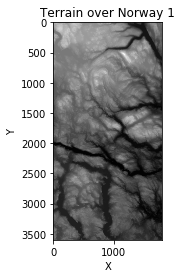

In [2]:
# Load the terrain
terrain1 = imread('SRTM_data_Norway_1.tif')
# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain1, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [3]:
terrain1.shape

(3601, 1801)

In [4]:
terrain1

Array([[1161, 1165, 1169, ...,  931,  922,  922],
       [1168, 1171, 1174, ...,  941,  928,  922],
       [1172, 1173, 1176, ...,  945,  934,  924],
       ...,
       [ 673,  677,  681, ...,  300,  300,  297],
       [ 675,  677,  681, ...,  296,  297,  294],
       [ 677,  680,  682, ...,  292,  294,  292]], dtype=int16)

The terrain data is the height, which is basically the z-function. X and Y are the points from 0-1801 and 0-3601 respectively. Making a meshgrid for Y from 0-3601 gives these points. 

In [5]:
x = np.arange(0, 1801)
y = np.arange(0, 3601)

xx, yy = np.meshgrid(x,y)

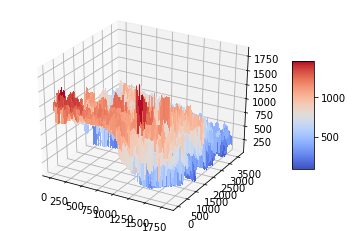

In [6]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(xx,yy,terrain1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [7]:
def CreateDesignMatrix_X(x, y, n = 5):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)
        
    N = len(x)
    l = int((n+1)*(n+2)/2)
    X = np.ones((N,l))
        
    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = x**(i-k) * y**k
    return X

In [8]:
m = 5        # degree of polynomial

#Transform from matrices to vectors, reduce the data by taking every fourth point 
x_1 = np.ravel(xx)[::4]
y_1 = np.ravel(yy)[::4]
z_1 = np.ravel(terrain1)[::4]

# finally create the design matrix
X = CreateDesignMatrix_X(x_1, y_1, n=m)

z_1.shape

(1621351,)

In [9]:
beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(z_1)
ztilde = X @ beta

ValueError: cannot reshape array of size 1621351 into shape (1801,)

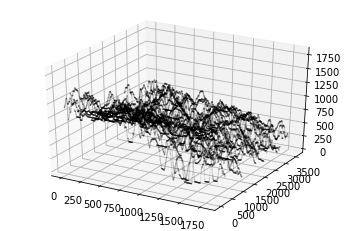

In [14]:
fig = plt.figure()
ax1 = fig.gca(projection='3d')

ax1.scatter(xx[::128], yy[::128], terrain1[::128], 
           alpha=0.5, 
           s=0.01, 
           color='black'
           )

ax1.plot_surface(xx[::128], yy[::128], ztilde.reshape(x.shape), 
                alpha=0.4, 
                cmap=cm.coolwarm,
                )

plt.title(f'OLS regression fit')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

norm = 1/X.std()    #Should we normalize the data?? How about taking it back to the normal values after that? 
Xtrain, Xtest, ztrain, ztest = train_test_split(X*norm, z_1*norm, test_size=0.2)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
z_scaled = scaler.fit_transform(terrain1)

z_scaled = np.ravel(z_scaled)

Xtrain, Xtest, ztrain, ztest = train_test_split(X_scaled, z_scaled, test_size=0.2)

In [ ]:
Xtrain, Xtest, ztrain, ztest = train_test_split(X, z_1, test_size=0.2)

'pinv' uses the SVD 'behind the scenes', if the matrix is not invertible it will use the SVD, if it is it will use normal inversion

In [ ]:
beta = np.linalg.pinv(Xtrain.T.dot(Xtrain)).dot(Xtrain.T).dot(ztrain)
ztilde = Xtrain @ beta

zpred = Xtest @ beta

In [ ]:
def MSE(z_data, z_model):
    n = np.size(z_model)
    return np.sum((z_data-z_model)**2)/n

print('MSE training:', MSE(ztrain, ztilde))
print('MSE test', MSE(ztest, zpred))

The MSE scores are crazy high because the data is not normalized. However, normalizing is not necessary for this project. 

In [ ]:
def R2(z_data, z_model):
    return 1 - np.sum((z_data - z_model) ** 2) / np.sum((z_data - np.mean(z_model)) ** 2)

print('R2 training:', R2(ztrain, ztilde))
print('R2 test', R2(ztest, zpred))